## Pixel CNN using MNIST data

### Importing Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### Collecting Data

In [3]:
tf.random.set_seed(42)
np.random.seed(42)
(X_train,Y_train),(X_test,Y_test) = keras.datasets.mnist.load_data()
height = 28
width = 28
channel = 1
X_train = X_train.reshape(X_train.shape[0],height,width,channel)
X_test = X_test.reshape(X_test.shape[0],height,width,channel)
threshold = 0.3
data = np.where(X_train<(threshold*256),0,1)
data = data.astype(np.uint8)

11490434/11490434 [==============================] - 0s 0us/step


### Visualizing data

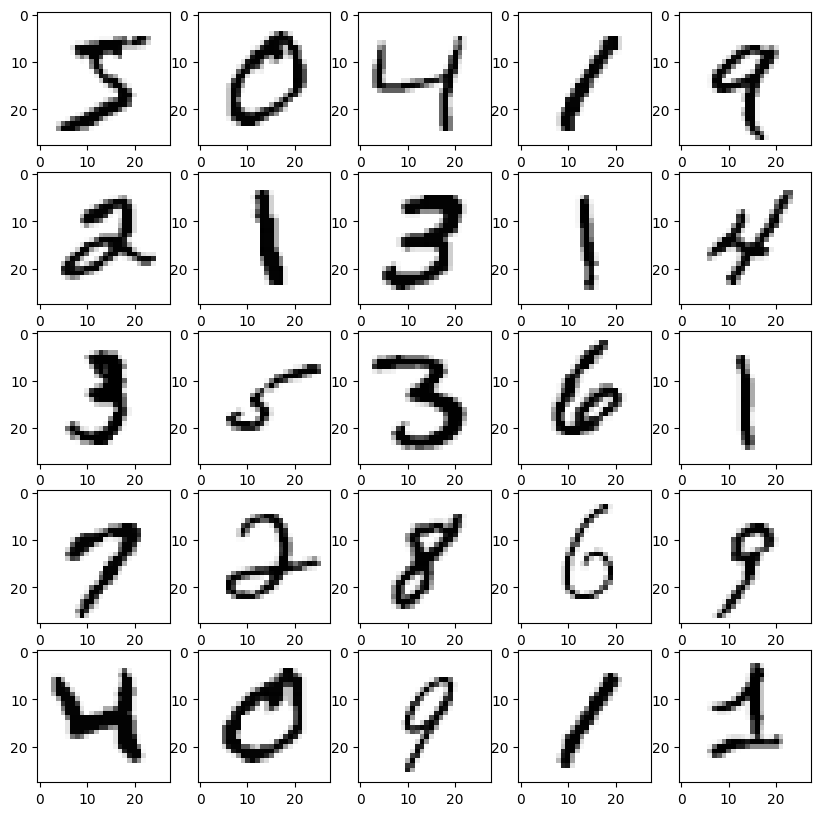

In [6]:
fig,ax = plt.subplots(nrows=5,ncols=5,figsize=(10,10))
k = 0
for i in range(5):
  for j in range(5):
    ax[i][j].imshow(X_train[k],cmap='Greys')
    k +=1
plt.savefig('drive/MyDrive/sampledata.png')

### PixelCNN Architechture

![picture](https://drive.google.com/uc?export=view&id=1r6r9KmnLEEJl-2rlu1kubjgGAl_261_J)

### Masked Convolutional Layer

In [7]:
class MaskedConvLayer(layers.Layer):
  def __init__(self,mask_type,filters,kernel_size,activation="relu",strides=1,padding='same'):
    super().__init__()
    self.mask_type = mask_type
    self.convlayer = layers.Conv2D(filters=filters,kernel_size=kernel_size,
                                   strides=strides,activation=activation
                                   ,padding=padding)
    self.kernel_size = kernel_size
  def build(self,input_shape):
    self.convlayer.build(input_shape)
    kernel_shape=self.convlayer.kernel.get_shape()
    self.mask = np.ones(shape=kernel_shape,dtype=np.float32)
    center = self.kernel_size//2
    self.mask[center,center+(self.mask_type=='B'):,:,:] = 0.
    self.mask[center+1:,:,:,:] = 0
  def call(self,inputs):
    self.convlayer.kernel.assign(self.convlayer.kernel*self.mask)
    return self.convlayer(inputs)

### Residual Block

In [8]:
class ResBlock(layers.Layer):
  def __init__(self,filters):
    super().__init__()
    self.conva = layers.Conv2D(filters=filters,kernel_size=1,activation="relu")
    self.convb = MaskedConvLayer(mask_type='B',filters=filters//2,kernel_size=3,
                              activation="relu",padding="same")
    self.convc = layers.Conv2D(filters=filters,kernel_size=1,activation="relu")
  def call(self,inputs):
    x = self.conva(inputs)
    x = self.convb(x)
    x = self.convc(x)
    return keras.layers.add([inputs,x])

### Model(Summary)

In [9]:
input_shape = (28,28,1)
inputs = keras.Input(shape=input_shape)
x = MaskedConvLayer(mask_type='A',filters=128,kernel_size=7,
                 strides=1,activation="relu",padding="same")(inputs)
for i in range(15):
  x = ResBlock(filters=128)(x)

x = MaskedConvLayer(mask_type='B',filters=128,kernel_size=1,
                  strides=1,activation="relu",padding="valid")(x)

x = MaskedConvLayer(mask_type='B',filters=128,kernel_size=1,
                  strides=1,activation="relu",padding="valid")(x)

output = layers.Conv2D(filters=1,kernel_size=1,
                  strides=1,activation="sigmoid",padding="valid")(x)

model = keras.Model(inputs,output)
adam = keras.optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=adam,loss=keras.losses.BinaryCrossentropy())
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 masked_conv_layer (MaskedC  (None, 28, 28, 128)       6400      
 onvLayer)                                                       
                                                                 
 res_block (ResBlock)        (None, 28, 28, 128)       98624     
                                                                 
 res_block_1 (ResBlock)      (None, 28, 28, 128)       98624     
                                                                 
 res_block_2 (ResBlock)      (None, 28, 28, 128)       98624     
                                                                 
 res_block_3 (ResBlock)      (None, 28, 28, 128)       98624     
                                                             

### Training Our Model

In [ ]:
earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
model.fit(x=data,y=data,batch_size=128,epochs=50,validation_split=0.1,validation_freq=1,verbose=1,callbacks=[earlystop])

Epoch 1/50
422/422 [==============================] - 152s 293ms/step - loss: 0.1099 - val_loss: 0.0906
Epoch 2/50
422/422 [==============================] - 127s 301ms/step - loss: 0.0883 - val_loss: 0.0869
Epoch 3/50
422/422 [==============================] - 127s 301ms/step - loss: 0.0859 - val_loss: 0.0863
Epoch 4/50
422/422 [==============================] - 128s 303ms/step - loss: 0.0842 - val_loss: 0.0850
Epoch 5/50
422/422 [==============================] - 127s 302ms/step - loss: 0.0832 - val_loss: 0.0828
Epoch 6/50
422/422 [==============================] - 127s 302ms/step - loss: 0.0821 - val_loss: 0.0821
Epoch 7/50
422/422 [==============================] - 127s 301ms/step - loss: 0.0811 - val_loss: 0.0826
Epoch 8/50
422/422 [==============================] - 127s 301ms/step - loss: 0.0803 - val_loss: 0.0805
Epoch 9/50
422/422 [==============================] - 127s 302ms/step - loss: 0.0794 - val_loss: 0.0803
Epoch 10/50
422/422 [==============================] - 127s 302m

### Saving Our Trained Model

In [ ]:
import os
import datetime
def save_model(model,suffix=None):
  modeldir = os.path.join("drive/My Drive/",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  model_path = modeldir + suffix
  print(f"Saving Model to:{model_path}...")
  model.save(model_path)
  return model_path

In [ ]:
save_model(model,suffix="Pixelcnn")

Saving Model to:drive/My Drive/20231022-033256Pixelcnn...


'drive/My Drive/20231022-033256Pixelcnn'

### Generating Random Samples (New Images)

In [ ]:
samples = 25
px = np.ones((samples,28,28,1))

for i in range(28):
    for j in range(28):
      for c in range(1):
        p_new = model.predict(px)[:,i,j,c]
        px[:,i,j,c] = tf.math.ceil(p_new - tf.random.uniform(p_new.shape))

1/1 [==============================] - 0s 22ms/step


### Generated Samples Display

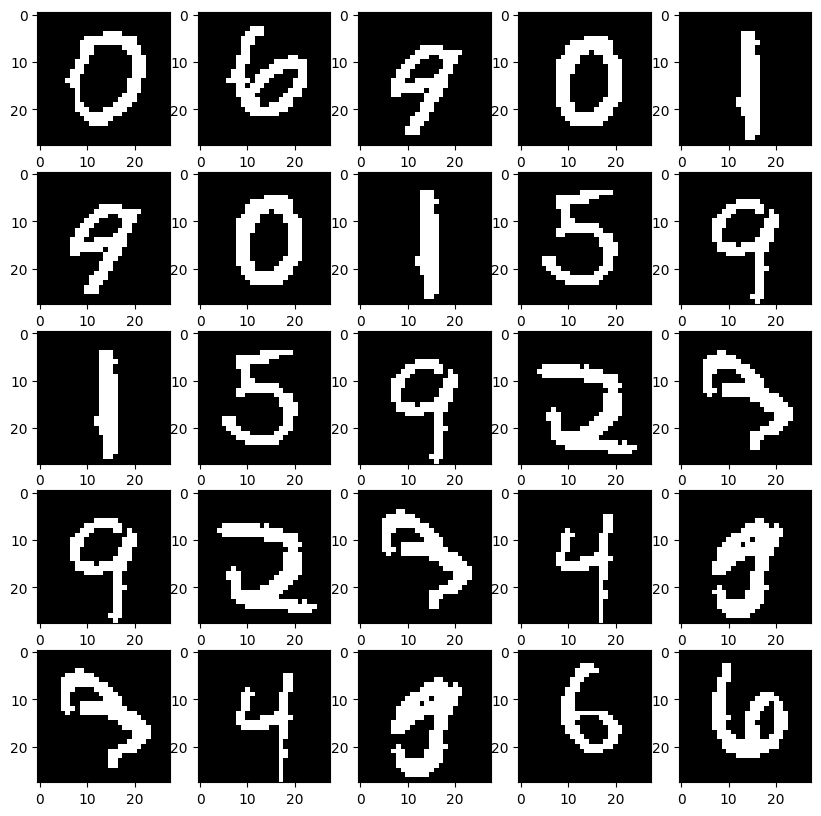

In [46]:
fig,ax = plt.subplots(5,5,figsize=(10,10))
for x in range(5,10):
    for y in range(5):
        img_ = np.squeeze(px[2*x+y],-1)
        img_ = np.stack((img_,img_,img_),2)
        img_ *= 255.0
        img_ = np.clip(img_,0,255).astype("uint8")
        ax[x-5,y].imshow(img_)
plt.savefig('drive/MyDrive/Generatedsamples.png')

### Loading Our Saved Model

In [59]:
import tensorflow_hub as hub

In [60]:
def load_model(model_path):
  model = tf.keras.models.load_model(model_path,custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [61]:
loadedmodel = load_model("/content/drive/MyDrive/20231022-033256Pixelcnn")

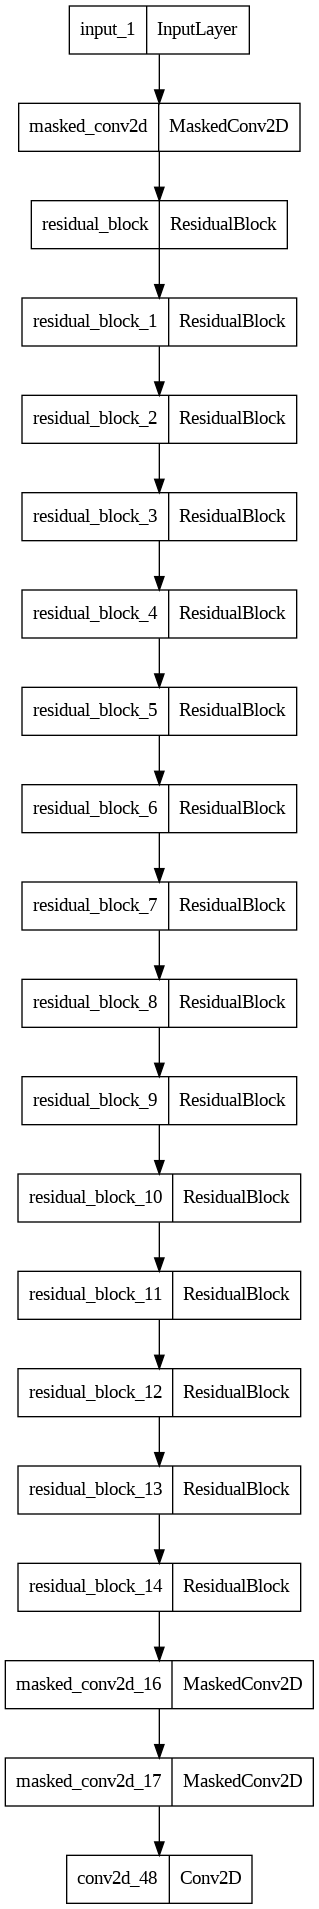

In [62]:
from keras.utils import plot_model
plot_model(loadedmodel, to_file='drive/MyDrive/model.png')

In [68]:
test_data = np.where(X_test<(threshold*256),0,1)
test_data = test_data.astype('uint8')

### Testing Our Model on Incomplete Images

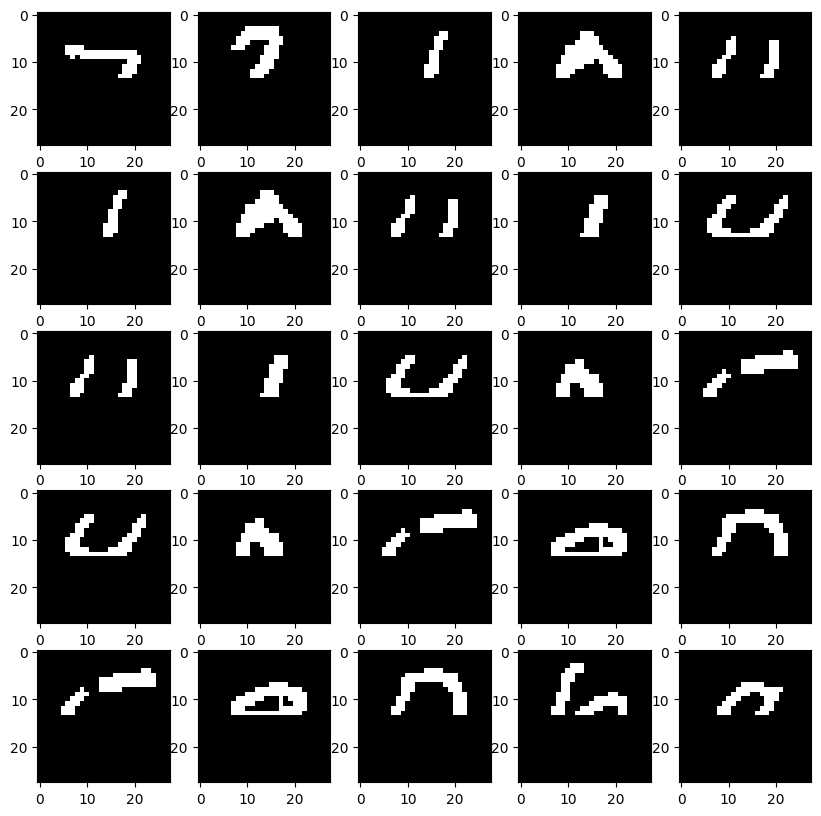

In [69]:
incomplete = np.ones(test_data.shape)
for i in range(incomplete.shape[0]):
  for j  in range(incomplete.shape[1]):
    if j>=14:
      incomplete[i][j] = 0
test_data = test_data*incomplete
fig,ax = plt.subplots(5,5,figsize=(10,10))
for x in range(5):
    for y in range(5):
        img_ = np.squeeze(test_data[2*x+y],-1)
        img_ = np.stack((img_,img_,img_),2)
        img_ *= 255
        img_ = np.clip(img_,0,255).astype("uint8")
        ax[x,y].imshow(img_)
plt.savefig('drive/MyDrive/IncompleteImages.png')

In [70]:
test_samples = 25
px = test_data[:25,:,:,:]
for i in range(14,28):
    for j in range(28):
      for c in range(1):
        p_new = loadedmodel.predict(px)[:,i,j,c]
        px[:,i,j,c] = tf.math.ceil(p_new - tf.random.uniform(p_new.shape))

1/1 [==============================] - 0s 22ms/step


### Displaying Completely Generated Images

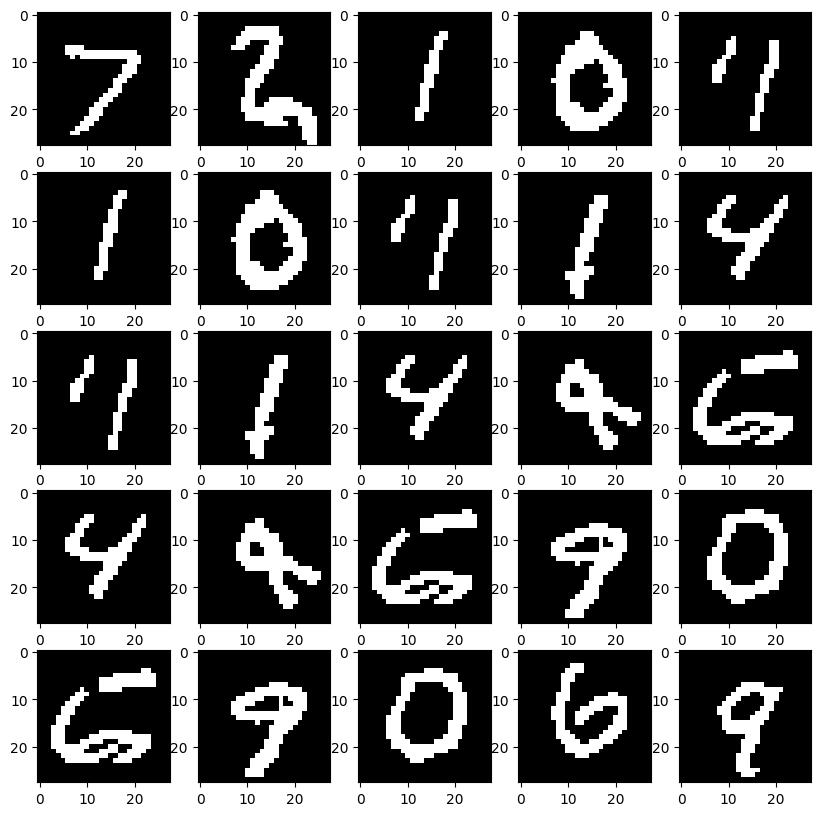

In [71]:
fig,ax = plt.subplots(5,5,figsize=(10,10))
for x in range(5):
    for y in range(5):
        img_ = np.squeeze(px[2*x+y],-1)
        img_ = np.stack((img_,img_,img_),2)
        img_ *= 255.0
        img_ = np.clip(img_,0,255).astype("uint8")
        ax[x-5,y].imshow(img_)
plt.savefig('drive/MyDrive/GeneratedCompleteImages.png')

From the above images we can observe that our model has performed well on test set generating new samples from incomplete image input.
We can further train this model on RGB datasets like CIFAR-10 and verify its accuracy on test dataset